<a href="https://colab.research.google.com/github/zinebzannouti/Statistics-With-Python/blob/main/6_Statistial_Experiments_and_Significance_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Statistial Experiments and Significance Testing**

**Import required Python packages**

In [1]:
%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

In [2]:
WEB_PAGE_DATA_CSV = 'https://raw.githubusercontent.com/gedeck/practical-statistics-for-data-scientists/master/data/web_page_data.csv'
FOUR_SESSIONS_CSV ='https://raw.githubusercontent.com/gedeck/practical-statistics-for-data-scientists/master/data/four_sessions.csv'
CLICK_RATE_CSV = 'https://raw.githubusercontent.com/gedeck/practical-statistics-for-data-scientists/master/data/click_rates.csv'
IMANISHI_CSV = 'https://raw.githubusercontent.com/gedeck/practical-statistics-for-data-scientists/master/data/imanishi_data.csv'

**Resampling**

In [3]:
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)
session_times.Time = 100 * session_times.Time

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


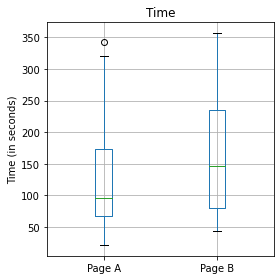

In [4]:
ax = session_times.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')

plt.tight_layout()
plt.show()

In [5]:
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
print(mean_b - mean_a)

35.66666666666667


In [10]:
# Permutation test example with stickiness
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[list(idx_B)].mean() - x.loc[list(idx_A)].mean()
    
nA = session_times[session_times.Page == 'Page A'].shape[0]
nB = session_times[session_times.Page == 'Page B'].shape[0]
print(perm_fun(session_times.Time, nA, nB))

-13.590476190476181


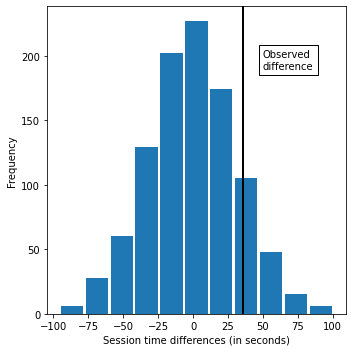

In [7]:
random.seed(1)
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = mean_b - mean_a, color='black', lw=2)
ax.text(50, 190, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [8]:
# convert perm_diffs to numpy array to avoid problems with some Python installations
perm_diffs = np.array(perm_diffs)
print(np.mean(perm_diffs > mean_b - mean_a))

0.121


**Statistical Significance and P-Values**

Observed difference: 0.0368%


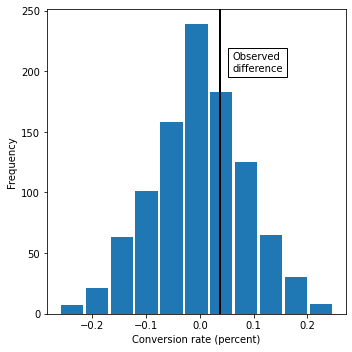

In [9]:
random.seed(1)
obs_pct_diff = 100 * (200 / 23739 - 182 / 22588)
print(f'Observed difference: {obs_pct_diff:.4f}%')
conversion = [0] * 45945
conversion.extend([1] * 382)
conversion = pd.Series(conversion)

perm_diffs = [100 * perm_fun(conversion, 23739, 22588) 
              for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

**P-Value**

If np.mean is applied to a list of booleans, it gives the percentage of how often True was found in the list (#True / #Total).

In [11]:
print(np.mean([diff > obs_pct_diff for diff in perm_diffs]))

0.332


In [12]:
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)

print(f'p-value for single sided test: {p_value / 2:.4f}')

p-value for single sided test: 0.3498


**t-Tests**

In [13]:
res = stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time, 
                      session_times[session_times.Page == 'Page B'].Time,
                      equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}')

p-value for single sided test: 0.1408


In [14]:
tstat, pvalue, df = sm.stats.ttest_ind(
    session_times[session_times.Page == 'Page A'].Time, 
    session_times[session_times.Page == 'Page B'].Time,
    usevar='unequal', alternative='smaller')
print(f'p-value: {pvalue:.4f}')

p-value: 0.1408


**ANOVA**

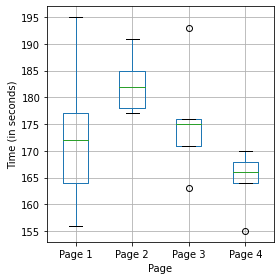

In [15]:
four_sessions = pd.read_csv(FOUR_SESSIONS_CSV)

ax = four_sessions.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('Page')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.title('')

plt.tight_layout()
plt.show()

In [16]:
print(pd.read_csv(FOUR_SESSIONS_CSV).head())

     Page  Time
0  Page 1   164
1  Page 2   178
2  Page 3   175
3  Page 4   155
4  Page 1   172


In [17]:
observed_variance = four_sessions.groupby('Page').mean().var()[0]
print('Observed means:', four_sessions.groupby('Page').mean().values.ravel())
print('Variance:', observed_variance)
# Permutation test example with stickiness
def perm_test(df):
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var()[0]
    
print(perm_test(four_sessions))

Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655
82.04


Pr(Prob) 0.07766666666666666


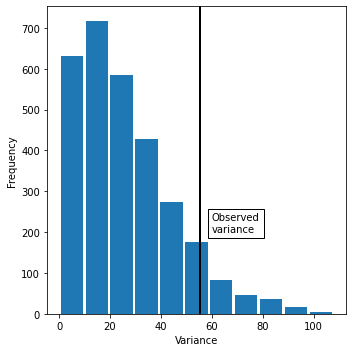

In [18]:
random.seed(1)
perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_variance, bins=11, rwidth=0.9)
ax.axvline(x = observed_variance, color='black', lw=2)
ax.text(60, 200, 'Observed\nvariance', bbox={'facecolor':'white'})
ax.set_xlabel('Variance')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()